# [참고한 커널](https://www.kaggle.com/sidharth178/top-10-house-price-prediction#2.-Install-&-Import-Libraries)
[커널 주인 깃허브](https://github.com/sidharth178/House-Prices-Advanced-Regression-Techniques/blob/master/House_Price_Prediction.ipynb)

## 추가학습요망
### 본 커널스터디 중 유익한 내용
[PowerTransform](https://runebook.dev/ko/docs/scikit_learn/modules/generated/sklearn.preprocessing.powertransformer)

[스케일링 참고](https://mkjjo.github.io/python/2019/01/10/scaler.html)

[파이프라인 사용 예](https://rk1993.tistory.com/entry/Python-sklearnpipeline-%ED%8C%8C%EC%9D%B4%ED%94%84%EB%9D%BC%EC%9D%B8Pipeline%EC%9D%B4%EB%9E%80)

[정규화모델 쉬운 이해](https://brunch.co.kr/@itschloe1/11)

[부스팅 모델 추가학습](http://dmqm.korea.ac.kr/activity/seminar/323)


[Lazy Predict documentation](https://pypi.org/project/lazypredict/)

[Optuna](https://ssoonidev.tistory.com/107)


### 다음 스터디 주제(캐글 코스타리카 가계신용) 예습(모델 해석, importance를 통한 데이터 차원 축소 관련)
[eli5 documentation](https://eli5.readthedocs.io/en/latest/index.html)

[고려대 LIME, SHAP 소개 세미나 영상](http://dmqm.korea.ac.kr/activity/seminar/297)

[SHAP의 특성 블로그](https://datanetworkanalysis.github.io/2019/12/23/shap1)

[LIME과 SHAP의 차이](https://eair.tistory.com/30)

# 라이브러리 설치 및 임포트

In [3]:
# 항상 최신 버전을 확인 후 사용하기

!pip install --user lazypredict==0.2.9

  Using cached lazypredict-0.2.9-py2.py3-none-any.whl (12 kB)
  Using cached lightgbm-2.3.1-py2.py3-none-win_amd64.whl (544 kB)
  Using cached pandas-1.0.5-cp38-cp38-win_amd64.whl (8.9 MB)
  Using cached joblib-1.0.0-py3-none-any.whl (302 kB)
  Using cached xgboost-1.1.1-py3-none-win_amd64.whl (54.4 MB)
  Using cached scipy-1.5.4-cp38-cp38-win_amd64.whl (31.4 MB)
  Using cached tqdm-4.56.0-py2.py3-none-any.whl (72 kB)
  Using cached scikit_learn-0.23.1-cp38-cp38-win_amd64.whl (6.8 MB)
  Using cached pytest-5.4.3-py3-none-any.whl (248 kB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [5]:
import missingno as msno

from scipy import stats
from scipy.stats import norm, skew

from sklearn.preprocessing import RobustScaler, PowerTransformer, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# 별도 코딩없이 수많은 기본 모델들을 이용하여 fitting 및 예측성능까지 비교 가능. 2019년 MIT에서 개발
import lazypredict
from lazypredict.Supervised import LazyRegressor

# lazypredict를 통해 계산된 상위 n개 모델들에 대해 하이퍼 파라미터 튜닝
import optuna

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 이번 커널스터디에서는 joblib을 통해 피클 생성 작업 등 제반 사항을 학습할 것
import joblib

print('Libraries imported')

Libraries imported


# 데이터 로드 및 병합

In [7]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

combined_df = pd.concat([train, test], axis = 0)

display(train.head(), train.shape, test.head(), test.shape, combined_df.head(), combined_df.shape)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.00,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.00,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.00,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.00,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.00,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


(1460, 81)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.00,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.00,TA,TA,CBlock,TA,TA,No,Rec,468.00,LwQ,144.00,270.00,882.00,GasA,TA,Y,SBrkr,896,0,0,896,0.00,0.00,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.00,Unf,1.00,730.00,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.00,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.00,TA,TA,CBlock,TA,TA,No,ALQ,923.00,Unf,0.00,406.00,1329.00,GasA,TA,Y,SBrkr,1329,0,0,1329,0.00,0.00,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.00,Unf,1.00,312.00,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.00,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.00,TA,TA,PConc,Gd,TA,No,GLQ,791.00,Unf,0.00,137.00,928.00,GasA,Gd,Y,SBrkr,928,701,0,1629,0.00,0.00,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.00,Fin,2.00,482.00,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.00,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.00,TA,TA,PConc,TA,TA,No,GLQ,602.00,Unf,0.00,324.00,926.00,GasA,Ex,Y,SBrkr,926,678,0,1604,0.00,0.00,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.00,Fin,2.00,470.00,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.00,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.00,Gd,TA,PConc,Gd,TA,No,ALQ,263.00,Unf,0.00,1017.00,1280.00,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.00,0.00,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.00,RFn,2.00,506.00,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


(1459, 80)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706.00,Unf,0.00,150.00,856.00,GasA,Ex,Y,SBrkr,856,854,0,1710,1.00,0.00,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.00,RFn,2.00,548.00,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.00
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.00,Unf,0.00,284.00,1262.00,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.00,1.00,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.00,RFn,2.00,460.00,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.00
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.00,Unf,0.00,434.00,920.00,GasA,Ex,Y,SBrkr,920,866,0,1786,1.00,0.00,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.00,RFn,2.00,608.00,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.00
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216.00,Unf,0.00,540.00,756.00,GasA,Gd,Y,SBrkr,961,756,0,1717,1.00,0.00,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.00,Unf,3.00,642.00,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.00
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655.00,Unf,0.00,490.00,1145.00,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.00,0.00,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.00,RFn,3.00,836.00,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.00


(2919, 81)

# EDA
## train data

* **데이터 타입 확인**

In [11]:
# df.dtypes.value_counts()를 통해 모든 컬럼의 dtype 집계를 확인

train_dtype = train_df.dtypes
train_dtype.value_counts()

object     43
int64      35
float64     3
dtype: int64

* **null data 확인**

In [12]:
# 상위 20개만 추림
train_df.isnull().sum().sort_values(ascending = False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64

* **missingno의 히트맵은 결측치가 있는 컬럼들끼리의 상관관계를 보여준다.**
    * 컬럼명에서 볼 수 있듯이, basement가 들어간 컬럼은 그 컬럼들끼리 상관관계가 굉장히 높고, garage 관련 컬럼도 그렇다

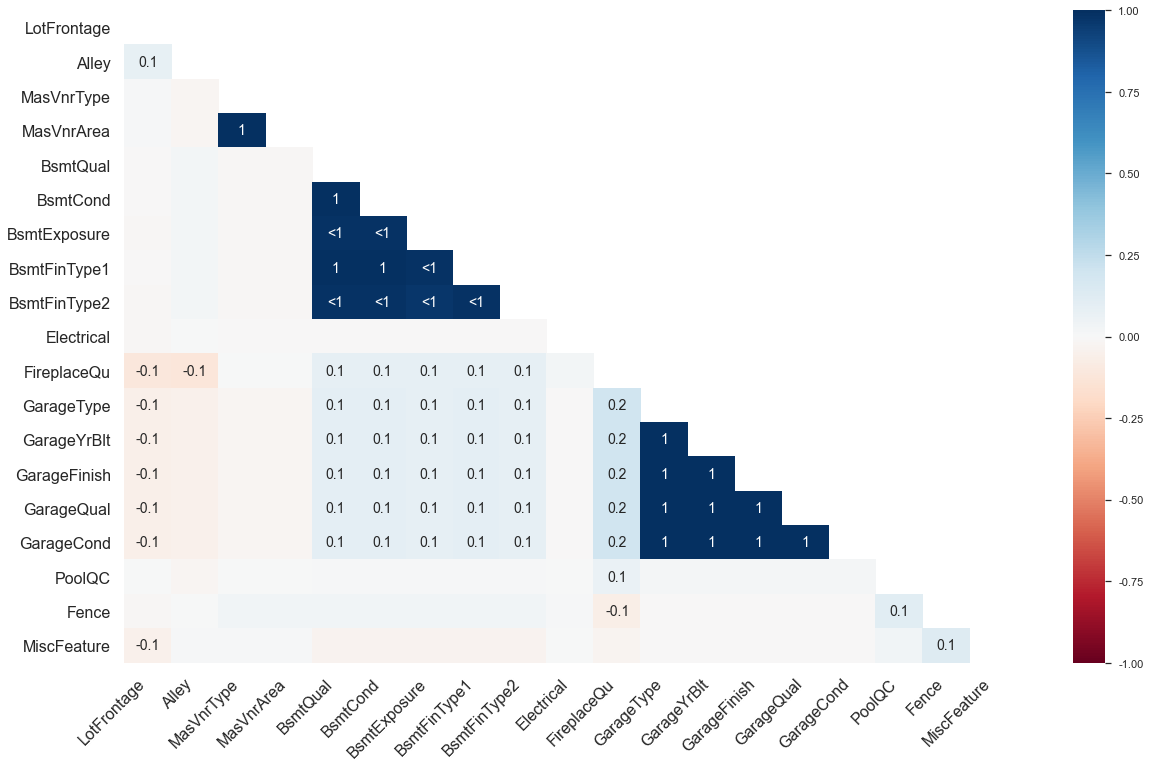

In [17]:
msno.heatmap(train_df)

plt.show()

## test data

In [20]:
test_dtype = test_df.dtypes
test_dtype.value_counts()

object     43
int64      26
float64    11
dtype: int64

In [24]:
test_df.isnull().sum().sort_values(ascending = False).head(20)

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageQual        78
GarageYrBlt       78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
dtype: int64

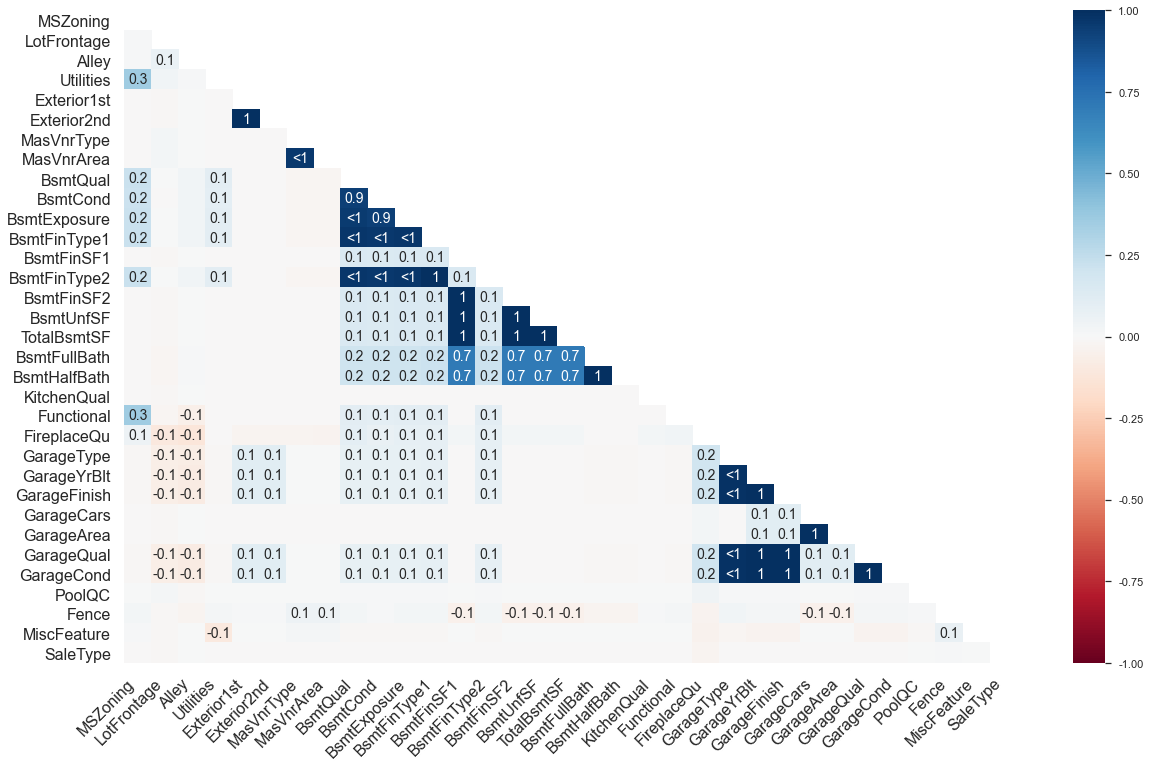

In [52]:
msno.heatmap(test_df)
plt.show()

## train data 와  test data 비교
### data type 비교

```python
df1.compare(df2) : df1과 df2의 값 중 다른 것을 출력. 두 df의 행렬은 같아야 함
```

In [54]:
# 8개의 변수가 하나는 int, 다른 하나는 float임. 그러나 큰 문제는 없으므로 pass!
train_dtype.drop('SalePrice', inplace = True)

train_dtype.compare(test_dtype)

,self,other
BsmtFinSF1,int64,float64
BsmtFinSF2,int64,float64
BsmtUnfSF,int64,float64
TotalBsmtSF,int64,float64
BsmtFullBath,int64,float64
BsmtHalfBath,int64,float64
GarageCars,int64,float64
GarageArea,int64,float64


### null count 비교

In [57]:
# PoolQC 등 상위 6개 컬럼의 null data가 굉장히 많다. 추후 drop할 것 고려

null_train = train_df.isnull().sum()
null_train.drop('SalePrice', inplace = True)
null_test = test_df.isnull().sum()

null_train.compare(null_test).sort_values(['self'], ascending = False)

,self,other
PoolQC,1453.00,1456.00
MiscFeature,1406.00,1408.00
Alley,1369.00,1352.00
Fence,1179.00,1169.00
FireplaceQu,690.00,730.00
LotFrontage,259.00,227.00
GarageType,81.00,76.00
GarageCond,81.00,78.00
GarageYrBlt,81.00,78.00
GarageFinish,81.00,78.00


### distribution 비교
* 첫번째 필사 노트북과 다른 방식으로 numeric과 categorical 구분함

In [82]:
# dtypes가 object가 아닌 것들을 전부 numerical_features에 할당함
numerical_features = [col for col in train_df.columns if train_df[col].dtypes != 'O']

# numerical이더라도, 재량에 따라 unique 값이 25개 이하라면 discrete으로 판단하여 discrete_features에 할당함(분석가의 의견에 따라)
discrete_features = [col for col in numerical_features if len(train_df[col].unique()) < 25 and col not in ['Id']]

# [col for col in numerical_features if len(train_df[col].unique()) < 25 and col != ['Id']] 이걸로 해도 됨
# [col for col in numerical_features if len(train_df[col].unique()) < 25] 이것도 결과는 같음
# Id는 누가 봐도 다 unique값이라 이산형도 연속형도 아닐텐데 굳이 이렇게 한 이유는.....

# numerical 중에 discrete에 해당하지 않는 나머지는 continuous_features에 할당함
continuous_features = [col for col in numerical_features if col not in discrete_features]

categorical_features = [col for col in train_df.columns if train_df[col].dtypes == 'O']

print("No. of Numerical features: ", len(numerical_features))
print("No. of discrete features: ", len(discrete_features))
print("No. of continuous features: ", len(continuous_features))
print("No. of categorical features: ", len(categorical_features))

No. of Numerical features:  38
No. of discrete features:  18
No. of continuous features:  20
No. of categorical features:  43


In [85]:
# 아래의 분포 비교 그래프를 그리기 위해 combined_df에 Label 행을 추가하여 train과 test를 구분함.
combined_df['Label'] = 'test'
combined_df['Label'][:1460] = 'train'

#### Discrete features' distribution

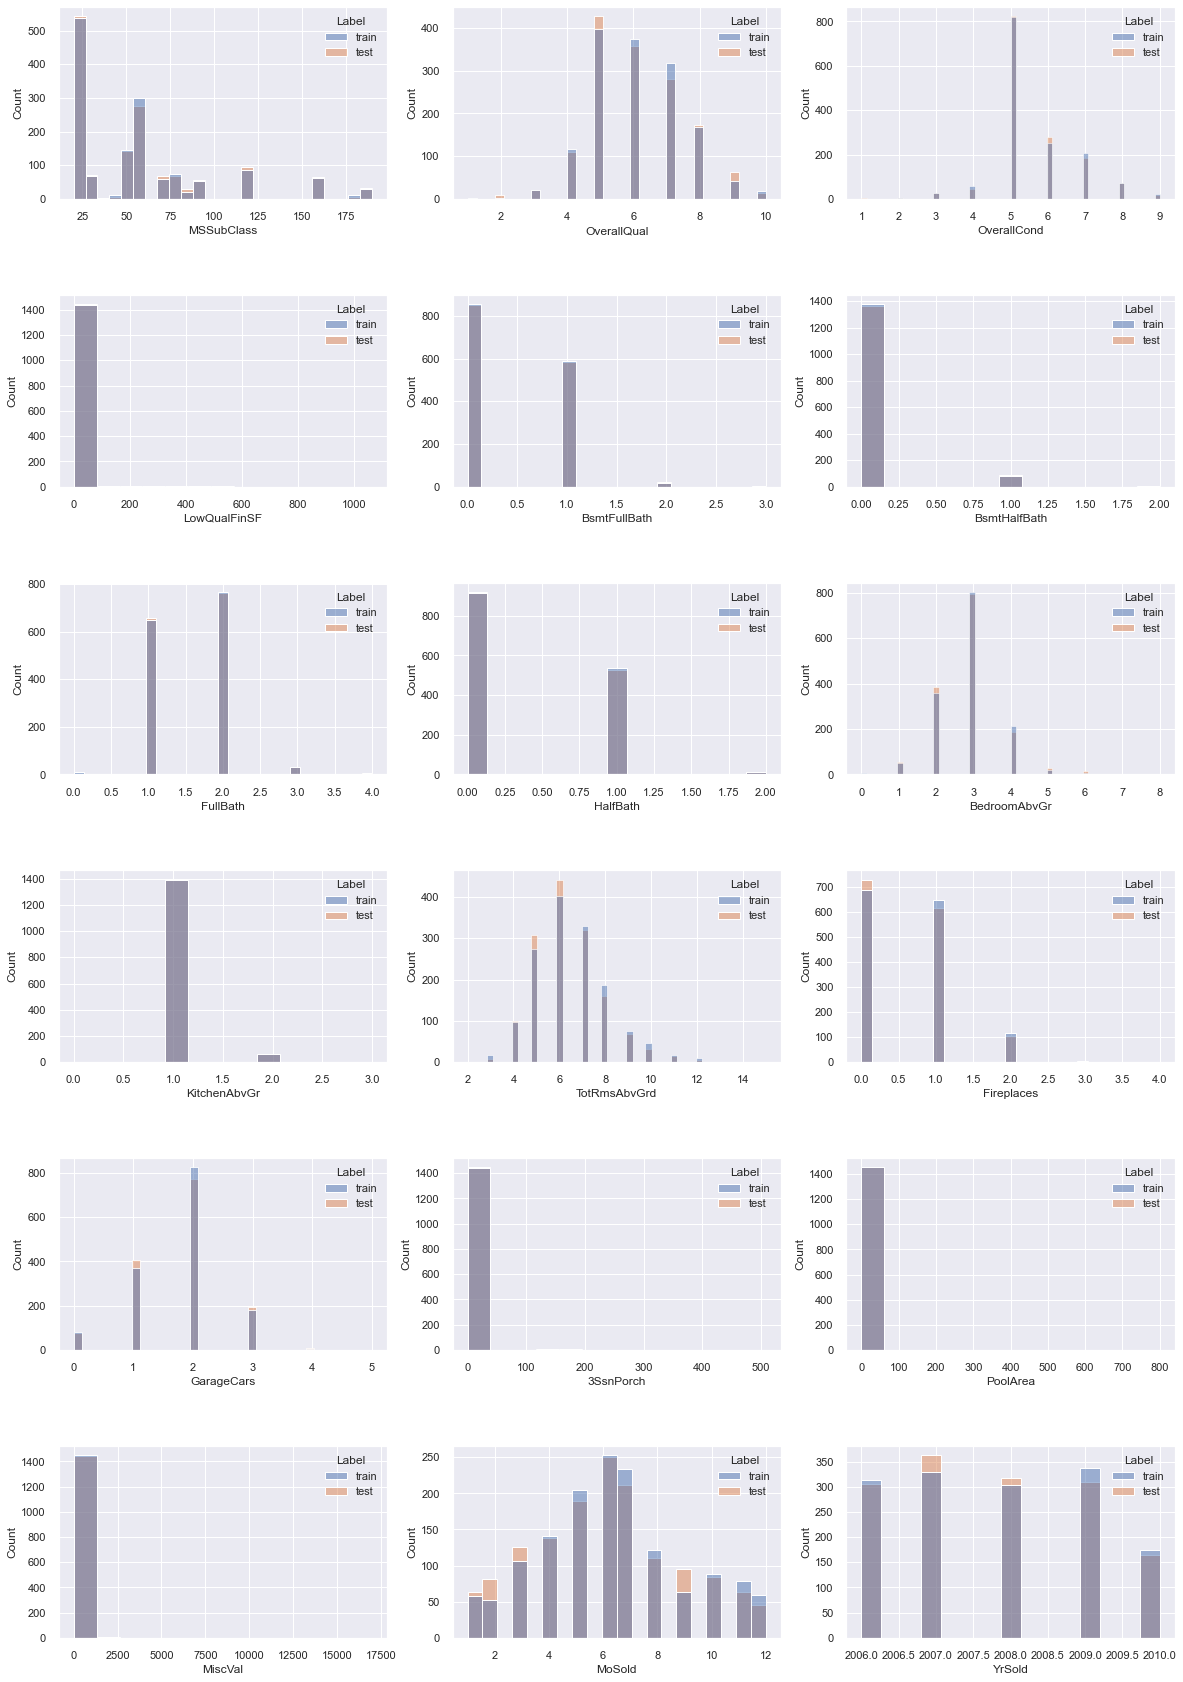

In [94]:
fig, axes = plt.subplots(6, 3, figsize = (20, 30))

for i, feature in enumerate(discrete_features):
    sns.histplot(data = combined_df, x = feature, hue = 'Label', ax = axes[i//3][i%3])
    plt.subplots_adjust(hspace = 0.5)

* **MSSubclass, OverallQual, OverallCond 등 숫자로 되어 있지만 categorical의 성격을 띄는 것이 보인다.**
* **LowQualFinSF, 3SsnPorch, PoolArea, MiscVal은 거의 전부가 0 또는 null로 되어 있으므로 본 컬럼 삭제 요망**

#### Continuous features' distribution

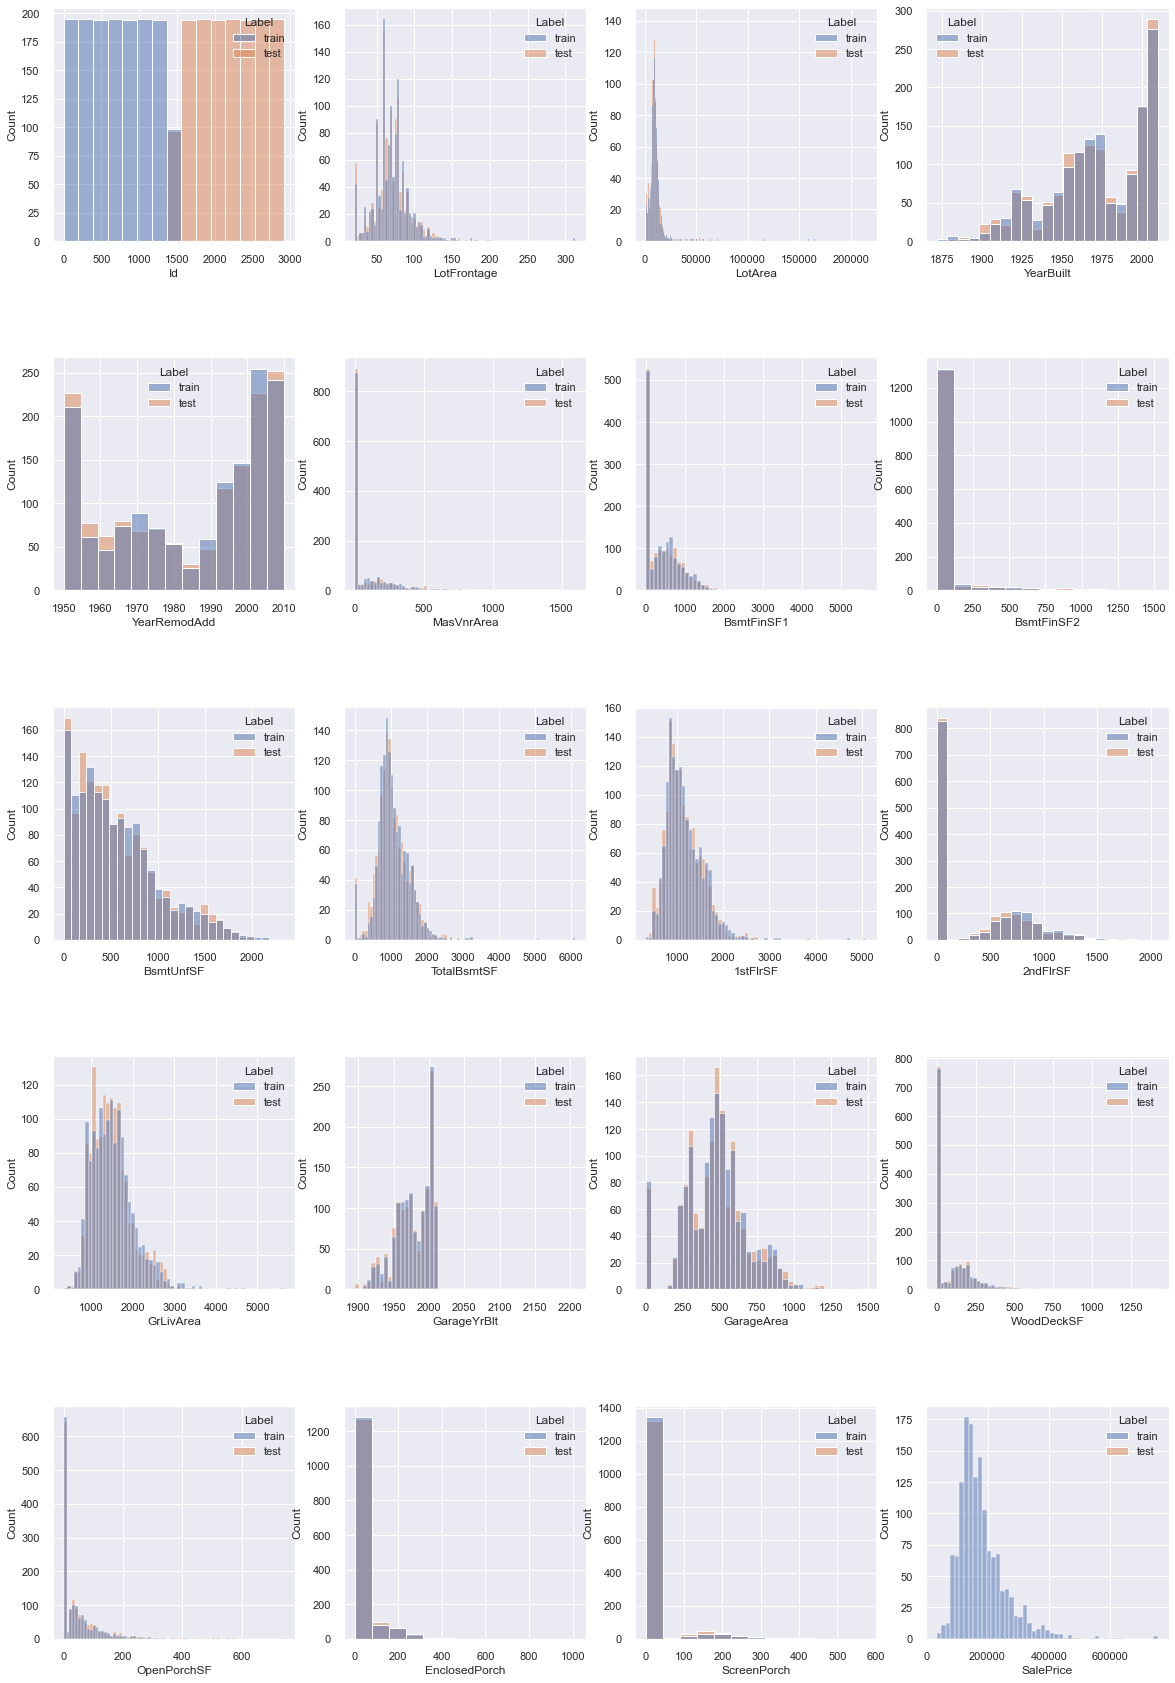

In [95]:
# 아래 그래프 중 Id, SalePrice는 무시하기 

fig, axes = plt.subplots(5, 4, figsize = (20, 30))

for i, feature in enumerate(continuous_features):
    sns.histplot(data = combined_df, x = feature, hue = 'Label', ax = axes[i//4][i%4])
    plt.subplots_adjust(hspace = 0.5)

* **train과 test 내의 continuous features는 비슷한 분포를 가지고 있다.**
* **값이 없는 feature들도 많으나, 연속형이므로 문제될 건 없다**

#### Linearity(선형성) 확인

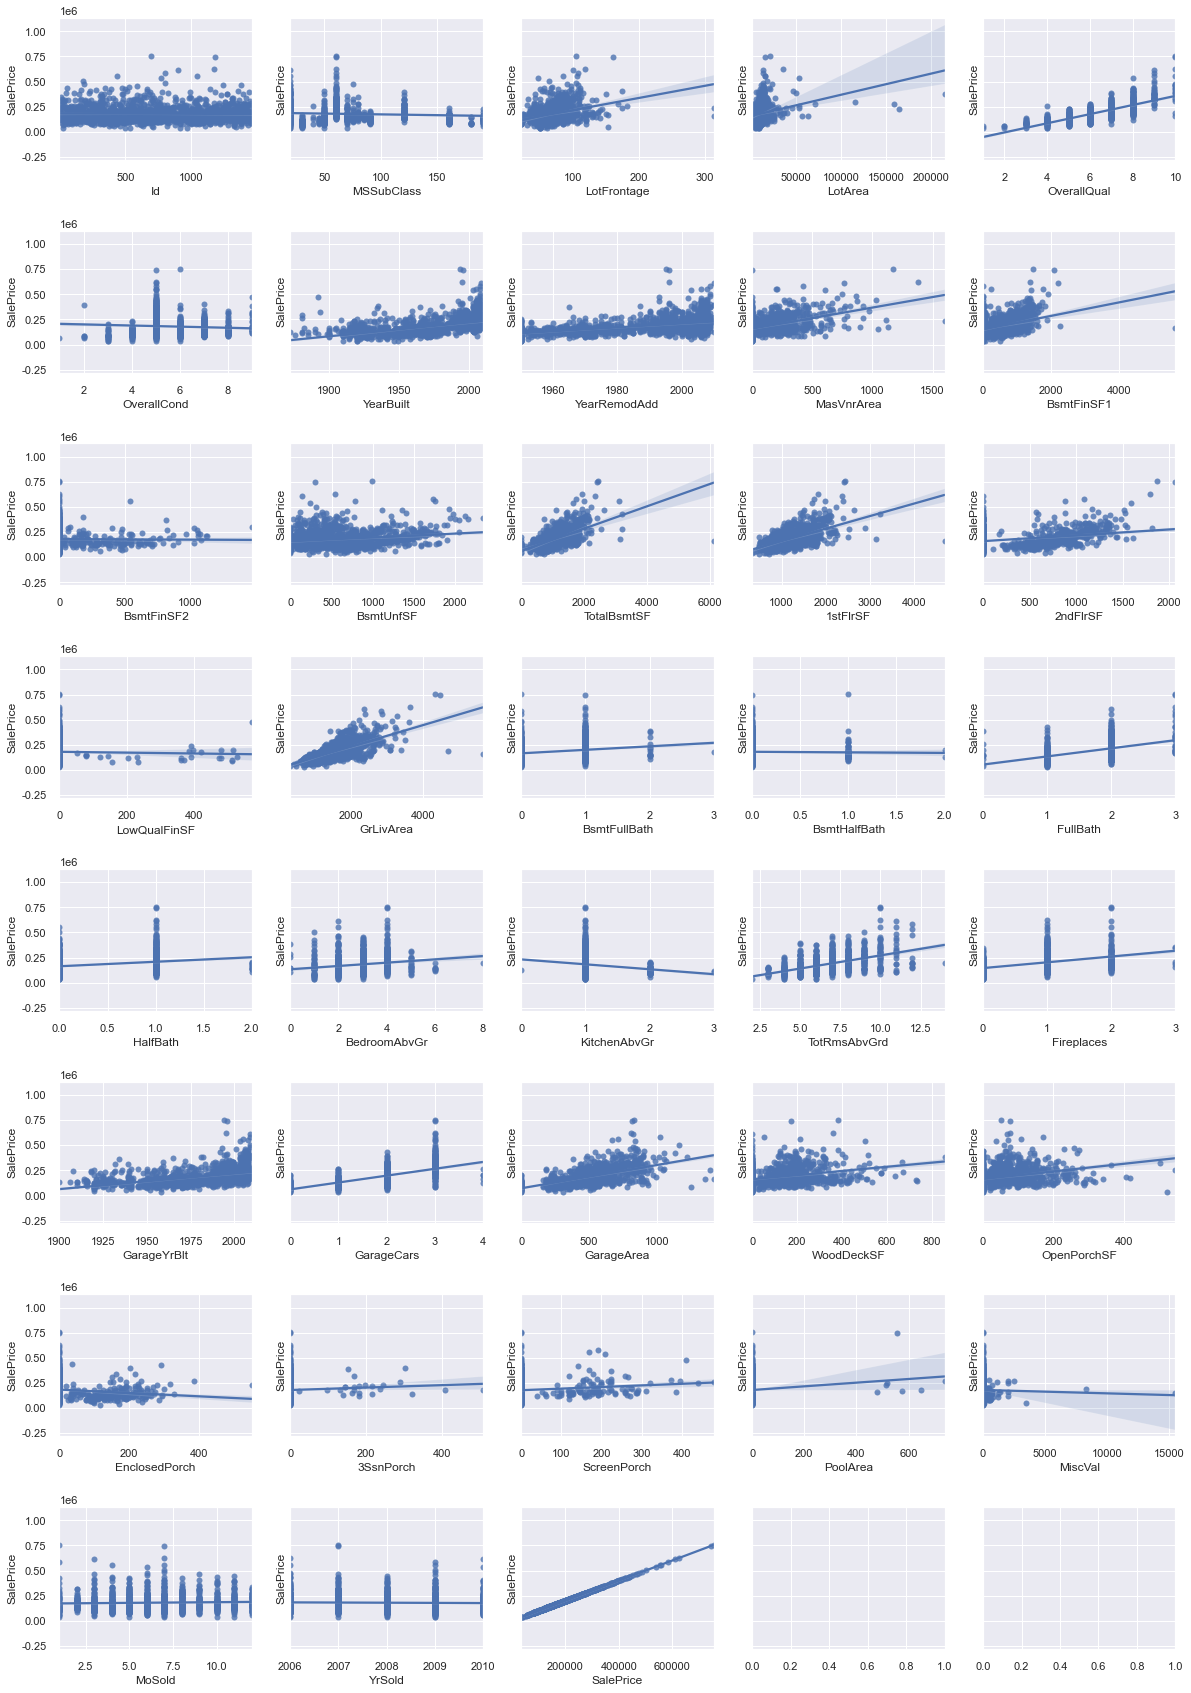

In [102]:
# 아래 그래프 중 Id, SalePrice는 무시하기 

fig, axes = plt.subplots(8, 5, figsize = (20, 30), sharey = True)

for i, feature in enumerate(numerical_features):
    sns.regplot(data = combined_df, x = feature, y = 'SalePrice', ax = axes[i//5][i%5])
    plt.subplots_adjust(hspace = 0.5)

* **연속형 변수 중 선형성이 없다고 해석되는 변수들**
* BsmtUnfSF, TotalBsmtSF, GarageArea, LotArea, LotFrontage, GrLivArea, 1stFlrSF

#### Numerical --> Categorical 로 바뀌어야 할 변수

* ['MSSubClass']

#### Categorical features' distribution

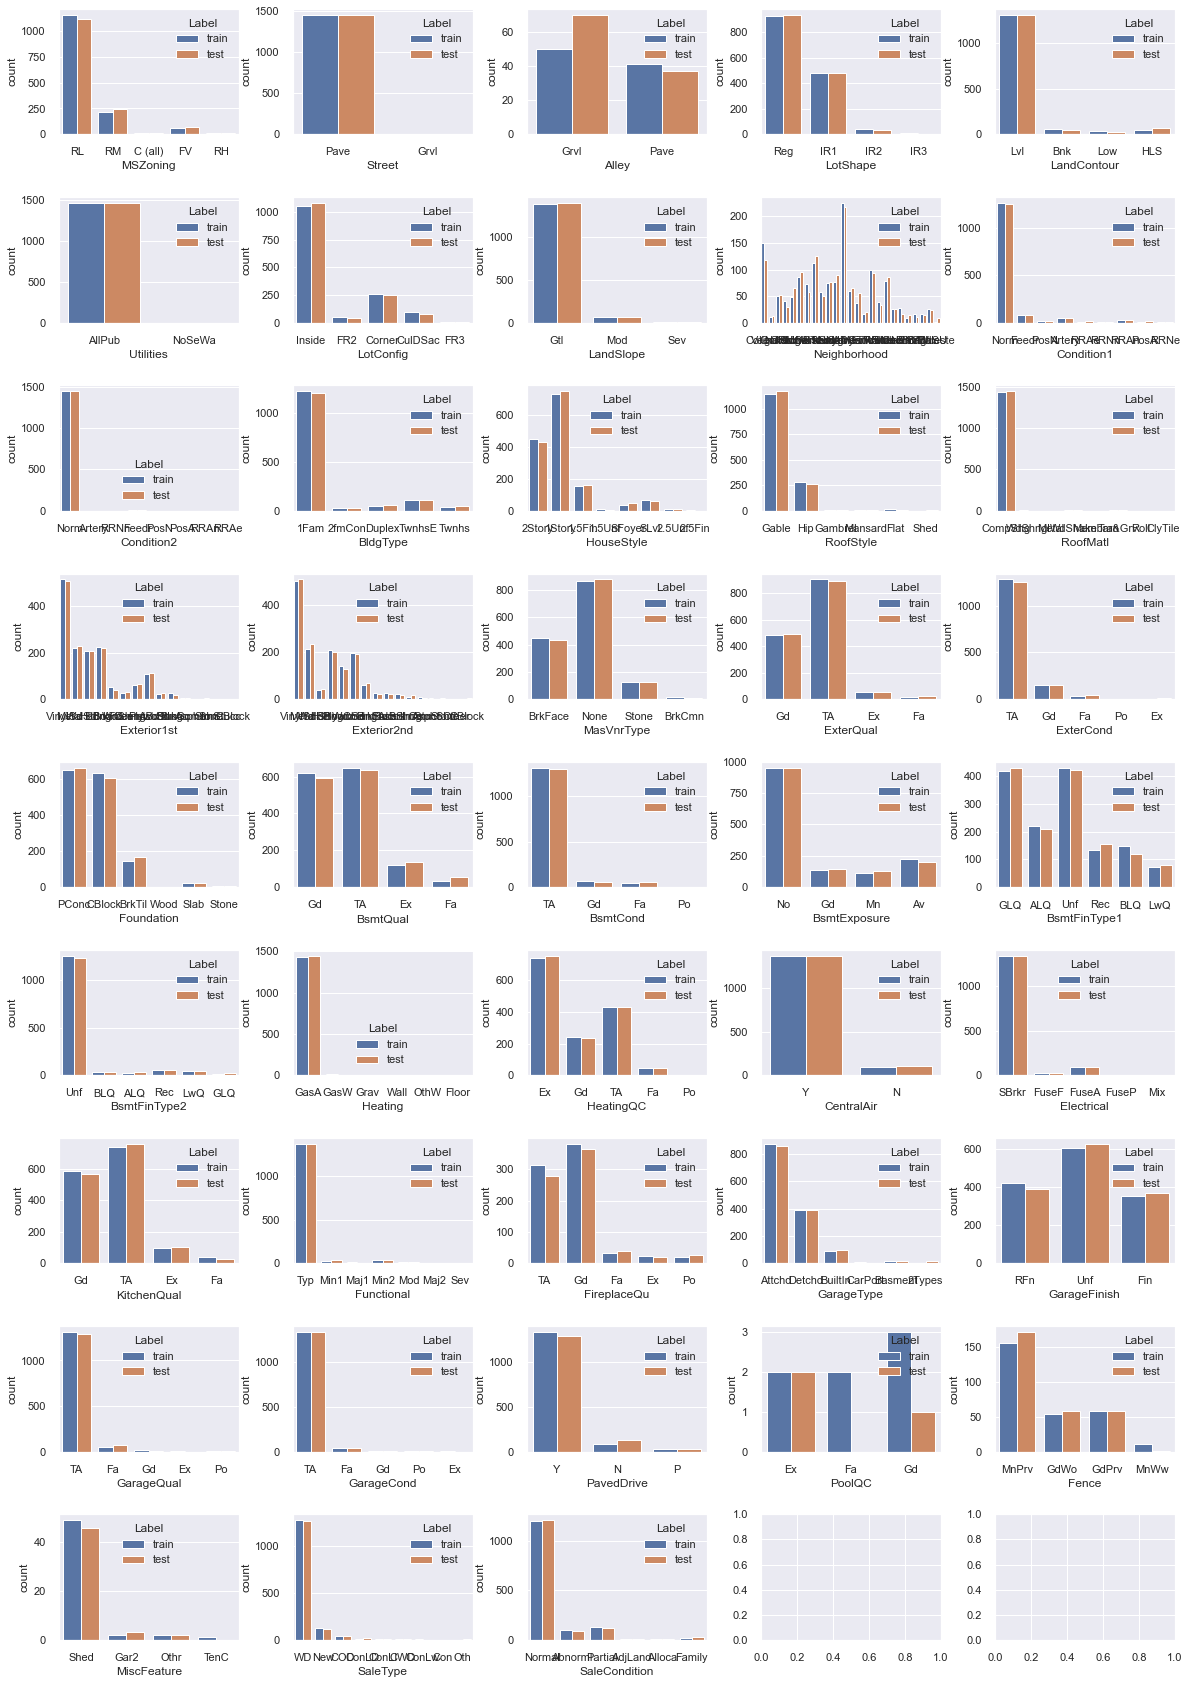

In [107]:
fig, axes = plt.subplots(9, 5, figsize = (20, 30))

for i, feature in enumerate(categorical_features):
    sns.countplot(data = combined_df, x = feature, hue = 'Label', ax = axes[i//5][i%5])
    plt.subplots_adjust(hspace = 0.5, wspace = 0.3)

* **train과 test의 분포가 비슷함**
* **몇몇 feature들은 dominant item을 가짐(데이터가 지나치게 한 클래스에 편중됨). 삭제 필요**
    * Street, LandContour, Utilities, LandSlope, Condition1, Condition2, BldgType, RoofMatl, ExterCond, BsmtCond, BsmtFinType2, Heating, CentralAir, Electrical, Functional, GarageQual, GarageCond, PavedDrive, MiscFeature, SaleType, SaleCondition

### 수치형 변수의 null data를 무엇으로 채울까?
* mean, median distribution을 비교

In [115]:
null_numerical_features =[col for col in combined_df.columns 
                          if combined_df[col].isnull().sum() > 0 
                          and col not in categorical_features]

null_numerical_features

['LotFrontage',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'SalePrice']

In [127]:
for col in null_numerical_features:
    print(col + ' 평균: ', combined_df[col].mean())

LotFrontage 평균:  69.30579531442663
MasVnrArea 평균:  102.20131215469613
BsmtFinSF1 평균:  441.4232350925291
BsmtFinSF2 평균:  49.58224811514736
BsmtUnfSF 평균:  560.7721041809458
TotalBsmtSF 평균:  1051.7775873886224
BsmtFullBath 평균:  0.429893726431265
BsmtHalfBath 평균:  0.06136441549537196
GarageYrBlt 평균:  1978.1134057971014
GarageCars 평균:  1.7666209732693625
GarageArea 평균:  472.8745716244003
SalePrice 평균:  180921.19589041095


In [129]:
for col in null_numerical_features:
    print(col + ' 중앙값: ', combined_df[col].median())

LotFrontage 중앙값:  68.0
MasVnrArea 중앙값:  0.0
BsmtFinSF1 중앙값:  368.5
BsmtFinSF2 중앙값:  0.0
BsmtUnfSF 중앙값:  467.0
TotalBsmtSF 중앙값:  989.5
BsmtFullBath 중앙값:  0.0
BsmtHalfBath 중앙값:  0.0
GarageYrBlt 중앙값:  1979.0
GarageCars 중앙값:  2.0
GarageArea 중앙값:  480.0
SalePrice 중앙값:  163000.0


* **중앙값이 0인 MasVnrArea, BsmtFinSF2는 0이 지나치게 많으므로 삭제해도 될 듯 하다.**
* **그 외에는 평균과 큰 차이가 없으므로 수치형 변수의 null은 평균으로 채우겠다**

In [136]:
combined_df['BsmtFinSF2'].value_counts()

0.00      2571
294.00       5
180.00       5
162.00       3
539.00       3
          ... 
196.00       1
904.00       1
456.00       1
624.00       1
823.00       1
Name: BsmtFinSF2, Length: 272, dtype: int64

# 전처리 

## 불필요한 컬럼 삭제
* discrete에서 삭제 요망 변수(거의 다 0 또는 null):
    * LowQualFinSF, 3SsnPorch, PoolArea, MiscVal
    
    
* categorical에서 삭제 요망 변수(한 클래스에 지나치게 편중:
    * Street, LandContour, Utilities, LandSlope, Condition1, Condition2, BldgType, RoofMatl, ExterCond, BsmtCond, BsmtFinType2, Heating, CentralAir, Electrical, Functional, GarageQual, GarageCond, PavedDrive, MiscFeature, SaleType, SaleCondition
    
    
* 추가로 만들었던 Label 컬럼, 불필요한 Id 컬럼 삭제

In [138]:
drop_col = ['LowQualFinSF', '3SsnPorch', 'PoolArea', 'MiscVal',
           'Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 
            'BldgType', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 
            'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'MiscFeature', 
            'SaleType', 'SaleCondition', 'Id', 'Label']

combined_df.drop(drop_col, axis = 1, inplace = True)

print(combined_df.shape)

(2919, 55)


## null data 채우기 

### Numerical

In [153]:
null_numerical_features = null_numerical_features[:11]   # SalePrice 제외

for col in null_numerical_features:
    combined_df[col].fillna(combined_df[col].mean(), inplace = True)

In [154]:
# SalePrice만 빼고 null data 잘 채워짐

[col for col in combined_df.columns 
                          if combined_df[col].isnull().sum() > 0 
                          and col not in categorical_features]

['SalePrice']

### Discrete

In [161]:
# discrete 에는 null 없음

[col for col in combined_df.columns 
                          if combined_df[col].isnull().sum() > 0 
                          and col in discrete_features]

[]

### Categorical

In [163]:
null_categorical_features = [col for col in combined_df.columns 
                          if combined_df[col].isnull().sum() > 0 
                          and col in categorical_features]

null_categorical_features

['MSZoning',
 'Alley',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinType1',
 'KitchenQual',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'PoolQC',
 'Fence']

In [175]:
for col in null_categorical_features:
    combined_df[col].fillna(combined_df[col].mode()[0], inplace = True)

In [176]:
[col for col in combined_df.columns 
                          if combined_df[col].isnull().sum() > 0 
                          and col in categorical_features]

[]

### MSSubClass 컬럼 dtype변경 

In [180]:
combined_df['MSSubClass'] = combined_df['MSSubClass'].astype('str')

combined_df['MSSubClass'].dtypes

dtype('O')

## PowerTransformer 이용하여 특정컬럼정규화

[docu](https://runebook.dev/ko/docs/scikit_learn/modules/generated/sklearn.preprocessing.powertransformer)

In [197]:
combined_df._get_numeric_data().skew().sort_values(ascending = False).head(15)

LotArea         12.83
KitchenAbvGr     4.30
BsmtFinSF2       4.15
EnclosedPorch    4.01
ScreenPorch      3.95
BsmtHalfBath     3.93
MasVnrArea       2.61
OpenPorchSF      2.54
SalePrice        1.88
WoodDeckSF       1.84
LotFrontage      1.65
1stFlrSF         1.47
BsmtFinSF1       1.43
GrLivArea        1.27
TotalBsmtSF      1.16
dtype: float64

In [199]:
log_list = ['LotArea', 'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch',
            'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF']

power = PowerTransformer(method = 'yeo-johnson', standardize = True)

for col in log_list:
    combined_df[col] = power.fit_transform(combined_df[[col]])    

## One-Hot Encoding

In [205]:
combined_df = pd.get_dummies(combined_df).reset_index(drop=True)

## train, test 데이터 분리 

In [216]:
new_train = combined_df.iloc[:len(train_df)]
new_test = combined_df.iloc[len(train_df):]

X_train = new_train.drop('SalePrice', axis = 1)
y_train = np.log1p(new_train['SalePrice'].values.ravel())
X_test = new_test.drop('SalePrice', axis = 1)

display(X_train.shape, y_train.shape, X_test.shape)

(1460, 191)

(1460,)

(1459, 191)

## 파이프라인 이용, Robust Scaling
* 위에서 처럼 선별적으로 로그를 취한 뒤, 아래와 같이 최종 스케일링을 하는 것이 좋다고들 한다.
* 다만 이 커널은 파이프라인에 RobustScaler만 넣었는데, 이는 파이프라인의 이점을 살리진 못한 것 같다.
    * RobustScaler를 그냥 단독으로 사용한 것과 make_pipeline으로 한 것과 효율성 측면에서 아무 차이가 없다는 의미
    * 추후에 SimpleImputer, OneHotEncoder, 모델생성 등을 함께 사용 시 pipeline을 이용하면 좋을 것이다.

[스케일링 참고](https://mkjjo.github.io/python/2019/01/10/scaler.html)

[파이프라인 사용 예](https://rk1993.tistory.com/entry/Python-sklearnpipeline-%ED%8C%8C%EC%9D%B4%ED%94%84%EB%9D%BC%EC%9D%B8Pipeline%EC%9D%B4%EB%9E%80)

In [217]:
pre_processing_pipeline = make_pipeline(RobustScaler())

X_train = pre_processing_pipeline.fit_transform(X_train)
X_test = pre_processing_pipeline.fit_transform(X_test)

# 모델링

## Lazy Predict를 이용하여 최적 알고리즘 탐색

[Lazy Predict documentation](https://pypi.org/project/lazypredict/)

[Lazy Predict 참고](https://package.wiki/lazypredict)

In [222]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X_train,y_train, test_size = 0.25, random_state = 1618)

reg = LazyRegressor(verbose=0, ignore_warnings = True, custom_metric = None)
train, test = reg.fit(x_train1, x_test1, y_train1, y_test1)

test[['R-Squared', 'RMSE', 'Time Taken']]

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:13<00:00,  3.21it/s]


,R-Squared,RMSE,Time Taken
Model,,,
HuberRegressor,0.91,0.12,0.16
GradientBoostingRegressor,0.90,0.12,0.53
HistGradientBoostingRegressor,0.90,0.12,3.84
LGBMRegressor,0.90,0.12,0.16
ElasticNetCV,0.90,0.13,0.20
LassoCV,0.90,0.13,0.21
LassoLarsCV,0.90,0.13,0.22
BayesianRidge,0.89,0.13,0.03
RandomForestRegressor,0.89,0.13,1.29


### 튜닝하여 사용할 모델
* 기본 회귀 삼총사
    * Ridge
    * Lasso
    * ElasticNet
    
    
* 앙상블 회귀 모델
[부스팅 모델 추가학습](http://dmqm.korea.ac.kr/activity/seminar/323)
    * GradientBoostingRegressor
    * LGBMRegressor
    * XGBRegressor

## Optuna 이용, hp튜닝
[참고블로그](https://ssoonidev.tistory.com/107)

* **주차예측대회 때의 경택's catboost 참고해서 optuna 추가 연습하기**

In [227]:
# 10-fold cross validation

RANDOM_SEED = 1618

kfolds = KFold(n_splits = 10, shuffle = True, random_state = RANDOM_SEED)

In [234]:
def tune(objective):
    study = optuna.create_study(direction = 'minimize')
    study.optimize(objective, n_trials = 100)
    
    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score} \nOptimized parameters: {params}")
    return params

### Ridge Regression

In [235]:
def ridge_objective(trial):
    _alpha = trial.suggest_float('alpha', 0.1, 20)
    ridge = Ridge(alpha = _alpha, random_state = RANDOM_SEED)
    
    score = -cross_val_score(
        ridge, X_train, y_train, cv = kfolds, scoring = 'neg_root_mean_squared_error'
    ).mean()
    return score

In [236]:
tune(ridge_objective)

[I 2021-08-27 10:12:58,005] A new study created in memory with name: no-name-e06bdf8f-c09c-462f-bc40-7f40a680818a
[I 2021-08-27 10:12:58,062] Trial 0 finished with value: 0.13831185732711984 and parameters: {'alpha': 12.932067912139164}. Best is trial 0 with value: 0.13831185732711984.
[I 2021-08-27 10:12:58,115] Trial 1 finished with value: 0.13850268024772996 and parameters: {'alpha': 16.574440378440908}. Best is trial 0 with value: 0.13831185732711984.
[I 2021-08-27 10:12:58,167] Trial 2 finished with value: 0.13853715134823336 and parameters: {'alpha': 17.186839836106035}. Best is trial 0 with value: 0.13831185732711984.
[I 2021-08-27 10:12:58,215] Trial 3 finished with value: 0.13844043553254565 and parameters: {'alpha': 15.444340424070788}. Best is trial 0 with value: 0.13831185732711984.
[I 2021-08-27 10:12:58,266] Trial 4 finished with value: 0.13855666872363764 and parameters: {'alpha': 17.530318112671868}. Best is trial 0 with value: 0.13831185732711984.
[I 2021-08-27 10:12:5

[I 2021-08-27 10:13:00,462] Trial 44 finished with value: 0.13819423111913248 and parameters: {'alpha': 5.905703594184847}. Best is trial 19 with value: 0.13815575793998283.
[I 2021-08-27 10:13:00,512] Trial 45 finished with value: 0.13817000080238398 and parameters: {'alpha': 9.02827422057958}. Best is trial 19 with value: 0.13815575793998283.
[I 2021-08-27 10:13:00,575] Trial 46 finished with value: 0.13824819736907848 and parameters: {'alpha': 11.495617622466028}. Best is trial 19 with value: 0.13815575793998283.
[I 2021-08-27 10:13:00,633] Trial 47 finished with value: 0.13835848829931763 and parameters: {'alpha': 4.1244624103915815}. Best is trial 19 with value: 0.13815575793998283.
[I 2021-08-27 10:13:00,692] Trial 48 finished with value: 0.1381559394960521 and parameters: {'alpha': 7.846100875858761}. Best is trial 19 with value: 0.13815575793998283.
[I 2021-08-27 10:13:00,751] Trial 49 finished with value: 0.13818152640484593 and parameters: {'alpha': 9.531353252477182}. Best i

[I 2021-08-27 10:13:02,823] Trial 88 finished with value: 0.1381585792106239 and parameters: {'alpha': 8.270446989013553}. Best is trial 71 with value: 0.13815575445533007.
[I 2021-08-27 10:13:02,873] Trial 89 finished with value: 0.13819094878488486 and parameters: {'alpha': 9.876020897345903}. Best is trial 71 with value: 0.13815575445533007.
[I 2021-08-27 10:13:02,927] Trial 90 finished with value: 0.1382842863061141 and parameters: {'alpha': 4.706377217249184}. Best is trial 71 with value: 0.13815575445533007.
[I 2021-08-27 10:13:02,980] Trial 91 finished with value: 0.13815576543487193 and parameters: {'alpha': 7.739076325881649}. Best is trial 71 with value: 0.13815575445533007.
[I 2021-08-27 10:13:03,034] Trial 92 finished with value: 0.1381576646448094 and parameters: {'alpha': 7.266137144047345}. Best is trial 71 with value: 0.13815575445533007.
[I 2021-08-27 10:13:03,084] Trial 93 finished with value: 0.13820632362841584 and parameters: {'alpha': 10.36969398394088}. Best is t

Best score: 0.13815575445533007 
Optimized parameters: {'alpha': 7.707606132117417}


{'alpha': 7.707606132117417}

In [264]:
ridge_params = {'alpha': 7.707606132117417}

ridge = Ridge(**ridge_params, random_state = RANDOM_SEED)

ridge.fit(X_train, y_train)

Ridge(alpha=7.707606132117417, random_state=1618)

### Lasso Regression

In [244]:
def lasso_objective(trial):
    _alpha = trial.suggest_float('alpha', 0.00001, 1)
    lasso = Lasso(alpha = _alpha, random_state = RANDOM_SEED)
    
    score = -cross_val_score(
        lasso, X_train, y_train, cv = kfolds, scoring = 'neg_root_mean_squared_error'
    ).mean()
    return score

In [245]:
tune(lasso_objective)

[I 2021-08-27 10:41:35,146] A new study created in memory with name: no-name-e059f28a-6205-403f-bdfa-4ff10f2932c6
[I 2021-08-27 10:41:35,217] Trial 0 finished with value: 0.36856688124941905 and parameters: {'alpha': 0.20340192847791455}. Best is trial 0 with value: 0.36856688124941905.
[I 2021-08-27 10:41:35,270] Trial 1 finished with value: 0.398577072891722 and parameters: {'alpha': 0.783502356767925}. Best is trial 0 with value: 0.36856688124941905.
[I 2021-08-27 10:41:35,323] Trial 2 finished with value: 0.398577072891722 and parameters: {'alpha': 0.6155298667892432}. Best is trial 0 with value: 0.36856688124941905.
[I 2021-08-27 10:41:35,378] Trial 3 finished with value: 0.398577072891722 and parameters: {'alpha': 0.7541988729099585}. Best is trial 0 with value: 0.36856688124941905.
[I 2021-08-27 10:41:35,436] Trial 4 finished with value: 0.39223516624960164 and parameters: {'alpha': 0.22266991314743387}. Best is trial 0 with value: 0.36856688124941905.
[I 2021-08-27 10:41:35,495

[I 2021-08-27 10:41:38,099] Trial 44 finished with value: 0.3962231953978649 and parameters: {'alpha': 0.2279552081071095}. Best is trial 38 with value: 0.13853744089598505.
[I 2021-08-27 10:41:38,168] Trial 45 finished with value: 0.19930846493820323 and parameters: {'alpha': 0.05098454320928969}. Best is trial 38 with value: 0.13853744089598505.
[I 2021-08-27 10:41:38,234] Trial 46 finished with value: 0.2430215338078075 and parameters: {'alpha': 0.0987665754185164}. Best is trial 38 with value: 0.13853744089598505.
[I 2021-08-27 10:41:38,339] Trial 47 finished with value: 0.14012600619672017 and parameters: {'alpha': 0.00124517207819198}. Best is trial 38 with value: 0.13853744089598505.
[I 2021-08-27 10:41:38,405] Trial 48 finished with value: 0.276130543905403 and parameters: {'alpha': 0.12925736130330764}. Best is trial 38 with value: 0.13853744089598505.
[I 2021-08-27 10:41:38,482] Trial 49 finished with value: 0.19717348956599706 and parameters: {'alpha': 0.04846628900020915}. 

[I 2021-08-27 10:41:43,016] Trial 88 finished with value: 0.22358758801666173 and parameters: {'alpha': 0.07806222725483157}. Best is trial 84 with value: 0.13735180677789707.
[I 2021-08-27 10:41:43,126] Trial 89 finished with value: 0.1395724431151249 and parameters: {'alpha': 0.0011451633900310169}. Best is trial 84 with value: 0.13735180677789707.
[I 2021-08-27 10:41:43,196] Trial 90 finished with value: 0.17510435656993958 and parameters: {'alpha': 0.026191503191892264}. Best is trial 84 with value: 0.13735180677789707.
[I 2021-08-27 10:41:43,280] Trial 91 finished with value: 0.15115404503416904 and parameters: {'alpha': 0.004585309582155915}. Best is trial 84 with value: 0.13735180677789707.
[I 2021-08-27 10:41:43,400] Trial 92 finished with value: 0.1407024907776429 and parameters: {'alpha': 0.0013392367532781605}. Best is trial 84 with value: 0.13735180677789707.
[I 2021-08-27 10:41:43,467] Trial 93 finished with value: 0.2053592630487217 and parameters: {'alpha': 0.05762533617

Best score: 0.13735180677789707 
Optimized parameters: {'alpha': 0.00035403286455208644}


{'alpha': 0.00035403286455208644}

In [260]:
lasso_params = {'alpha': 0.00035403286455208644}

lasso = Lasso(**lasso_params, random_state = RANDOM_SEED)

lasso.fit(X_train, y_train)

Lasso(alpha=0.00035403286455208644, random_state=1618)

### ElasticNet Regression

In [250]:
def ElasticNet_objective(trial):
    _alpha = trial.suggest_float('alpha', 0.00001, 1)
    _l1_ratio = trial.suggest_float('l1_ratio', 0.1, 1)
    elastic = ElasticNet(alpha = _alpha, l1_ratio = _l1_ratio, random_state = RANDOM_SEED)
    
    score = -cross_val_score(
        elastic, X_train, y_train, cv = kfolds, scoring = 'neg_root_mean_squared_error'
    ).mean()
    return score

In [251]:
tune(ElasticNet_objective)

[I 2021-08-27 10:46:56,959] A new study created in memory with name: no-name-5138aa09-6257-49df-abee-3e3d284c4675
[I 2021-08-27 10:46:57,028] Trial 0 finished with value: 0.20117631263790853 and parameters: {'alpha': 0.09189284552858126, 'l1_ratio': 0.54820913313643}. Best is trial 0 with value: 0.20117631263790853.
[I 2021-08-27 10:46:57,089] Trial 1 finished with value: 0.20201938594260532 and parameters: {'alpha': 0.10737465605940794, 'l1_ratio': 0.467093580144057}. Best is trial 0 with value: 0.20117631263790853.
[I 2021-08-27 10:46:57,148] Trial 2 finished with value: 0.2284001260844092 and parameters: {'alpha': 0.3996867449239374, 'l1_ratio': 0.15174185664053447}. Best is trial 0 with value: 0.20117631263790853.
[I 2021-08-27 10:46:57,203] Trial 3 finished with value: 0.3460528704485749 and parameters: {'alpha': 0.32213788684532346, 'l1_ratio': 0.5634363362141216}. Best is trial 0 with value: 0.20117631263790853.
[I 2021-08-27 10:46:57,252] Trial 4 finished with value: 0.39774070

[I 2021-08-27 10:47:00,477] Trial 37 finished with value: 0.3562747137701474 and parameters: {'alpha': 0.3658908353916659, 'l1_ratio': 0.5177603408691294}. Best is trial 22 with value: 0.13745127526978795.
[I 2021-08-27 10:47:00,544] Trial 38 finished with value: 0.24168551656881535 and parameters: {'alpha': 0.14530519784405474, 'l1_ratio': 0.6336469020578781}. Best is trial 22 with value: 0.13745127526978795.
[I 2021-08-27 10:47:00,615] Trial 39 finished with value: 0.18055771450456887 and parameters: {'alpha': 0.07330099418498469, 'l1_ratio': 0.4060414889227911}. Best is trial 22 with value: 0.13745127526978795.
[I 2021-08-27 10:47:00,677] Trial 40 finished with value: 0.24648348775917678 and parameters: {'alpha': 0.2895291000380142, 'l1_ratio': 0.2958439370810147}. Best is trial 22 with value: 0.13745127526978795.
[I 2021-08-27 10:47:00,772] Trial 41 finished with value: 0.1450912607909436 and parameters: {'alpha': 0.010484679803022364, 'l1_ratio': 0.20306494193599628}. Best is tria

[I 2021-08-27 10:47:03,966] Trial 75 finished with value: 0.13922746205255906 and parameters: {'alpha': 0.0030280123226369493, 'l1_ratio': 0.3380636043035258}. Best is trial 70 with value: 0.13735283299037948.
[I 2021-08-27 10:47:04,040] Trial 76 finished with value: 0.16832597732237858 and parameters: {'alpha': 0.032413204862486854, 'l1_ratio': 0.5969515979523643}. Best is trial 70 with value: 0.13735283299037948.
[I 2021-08-27 10:47:04,117] Trial 77 finished with value: 0.19946011666007663 and parameters: {'alpha': 0.11046945156111017, 'l1_ratio': 0.4214947992163286}. Best is trial 70 with value: 0.13735283299037948.
[I 2021-08-27 10:47:04,181] Trial 78 finished with value: 0.17091750740832168 and parameters: {'alpha': 0.06643108132296059, 'l1_ratio': 0.31617379020598907}. Best is trial 70 with value: 0.13735283299037948.
[I 2021-08-27 10:47:04,316] Trial 79 finished with value: 0.13817050808238815 and parameters: {'alpha': 0.003471936875366989, 'l1_ratio': 0.213086475440381}. Best i

Best score: 0.13735283299037948 
Optimized parameters: {'alpha': 0.0007107562278954604, 'l1_ratio': 0.47140117546028326}


{'alpha': 0.0007107562278954604, 'l1_ratio': 0.47140117546028326}

In [263]:
elastic_params = {'alpha': 0.0007107562278954604, 'l1_ratio': 0.47140117546028326}

elastic = ElasticNet(**elastic_params, random_state = RANDOM_SEED)

elastic.fit(X_train, y_train)

ElasticNet(alpha=0.0007107562278954604, l1_ratio=0.47140117546028326,
           random_state=1618)

### Gradient Boosting Regressor

In [253]:
def gbr_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _min_samp_split = trial.suggest_int("min_samples_split", 2, 20)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 20)
    _max_features = trial.suggest_int("max_features", 10, 50)

    gbr = GradientBoostingRegressor(
        n_estimators=_n_estimators,
        learning_rate=_learning_rate,
        max_depth=_max_depth, 
        max_features=_max_features,
        min_samples_leaf=_min_samples_leaf,
        min_samples_split=_min_samp_split,
        
        random_state=RANDOM_SEED,
    )

    score = -cross_val_score(
        gbr, X_train,y_train, cv=kfolds, scoring="neg_root_mean_squared_error"
    ).mean()
    return score

In [254]:
tune(gbr_objective)

[I 2021-08-27 10:51:38,567] A new study created in memory with name: no-name-2c281d80-3a23-4e21-915b-14c52e1a377a
[I 2021-08-27 10:51:50,577] Trial 0 finished with value: 0.1387368838371493 and parameters: {'n_estimators': 916, 'learning_rate': 0.16879958909986514, 'max_depth': 16, 'min_samples_split': 20, 'min_samples_leaf': 17, 'max_features': 10}. Best is trial 0 with value: 0.1387368838371493.
[I 2021-08-27 10:52:03,224] Trial 1 finished with value: 0.1498642599639134 and parameters: {'n_estimators': 1275, 'learning_rate': 0.43922081898798615, 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 15, 'max_features': 21}. Best is trial 0 with value: 0.1387368838371493.
[I 2021-08-27 10:52:27,717] Trial 2 finished with value: 0.14621600680320143 and parameters: {'n_estimators': 1974, 'learning_rate': 0.36968662378894984, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 28}. Best is trial 0 with value: 0.1387368838371493.
[I 2021-08-27 10:53:00,87

[I 2021-08-27 11:05:19,556] Trial 27 finished with value: 0.13692133920270846 and parameters: {'n_estimators': 1667, 'learning_rate': 0.19044025195736414, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 19, 'max_features': 32}. Best is trial 7 with value: 0.12707396935873783.
[I 2021-08-27 11:05:36,034] Trial 28 finished with value: 0.14765289829769415 and parameters: {'n_estimators': 1101, 'learning_rate': 0.38540717238403654, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 17, 'max_features': 14}. Best is trial 7 with value: 0.12707396935873783.
[I 2021-08-27 11:06:00,625] Trial 29 finished with value: 0.15763699942301918 and parameters: {'n_estimators': 969, 'learning_rate': 0.584806000055154, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 38}. Best is trial 7 with value: 0.12707396935873783.
[I 2021-08-27 11:07:20,594] Trial 30 finished with value: 0.13929574281160498 and parameters: {'n_estimators': 1373, 'learning_rate': 0.

[I 2021-08-27 11:19:23,954] Trial 55 finished with value: 0.12537217488487626 and parameters: {'n_estimators': 1287, 'learning_rate': 0.047283868737501934, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 18, 'max_features': 18}. Best is trial 55 with value: 0.12537217488487626.
[I 2021-08-27 11:19:30,854] Trial 56 finished with value: 0.12580841035143348 and parameters: {'n_estimators': 1328, 'learning_rate': 0.04991998246992944, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 18, 'max_features': 18}. Best is trial 55 with value: 0.12537217488487626.
[I 2021-08-27 11:19:46,896] Trial 57 finished with value: 0.13040100648975878 and parameters: {'n_estimators': 1459, 'learning_rate': 0.10196687800218644, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 18, 'max_features': 22}. Best is trial 55 with value: 0.12537217488487626.
[I 2021-08-27 11:19:54,128] Trial 58 finished with value: 0.12569307103910565 and parameters: {'n_estimators': 1210, 'learning_r

[I 2021-08-27 11:24:24,905] Trial 83 finished with value: 0.12852916428457944 and parameters: {'n_estimators': 1646, 'learning_rate': 0.054617055392542746, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 17, 'max_features': 14}. Best is trial 59 with value: 0.12507505857666287.
[I 2021-08-27 11:24:33,300] Trial 84 finished with value: 0.13491124659889953 and parameters: {'n_estimators': 1063, 'learning_rate': 0.12523867813059394, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 19, 'max_features': 16}. Best is trial 59 with value: 0.12507505857666287.
[I 2021-08-27 11:24:43,157] Trial 85 finished with value: 0.12830969273634316 and parameters: {'n_estimators': 1428, 'learning_rate': 0.014376316784250897, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 18, 'max_features': 28}. Best is trial 59 with value: 0.12507505857666287.
[I 2021-08-27 11:24:58,059] Trial 86 finished with value: 0.13053866729507096 and parameters: {'n_estimators': 1340, 'learning_r

Best score: 0.12507505857666287 
Optimized parameters: {'n_estimators': 1327, 'learning_rate': 0.048814550705770815, 'max_depth': 2, 'min_samples_split': 11, 'min_samples_leaf': 19, 'max_features': 19}


{'n_estimators': 1327,
 'learning_rate': 0.048814550705770815,
 'max_depth': 2,
 'min_samples_split': 11,
 'min_samples_leaf': 19,
 'max_features': 19}

In [265]:
gbr_params = {'n_estimators': 1327,
              'learning_rate': 0.048814550705770815,
              'max_depth': 2,
              'min_samples_split': 11,
              'min_samples_leaf': 19,
              'max_features': 19}

gbr = GradientBoostingRegressor(**gbr_params, random_state = RANDOM_SEED)

gbr.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.048814550705770815, max_depth=2,
                          max_features=19, min_samples_leaf=19,
                          min_samples_split=11, n_estimators=1327,
                          random_state=1618)

### XGB Regressor

In [255]:
def xgb_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _gamma = trial.suggest_float("gamma", 0.01, 1)
    _min_child_weight = trial.suggest_float("min_child_weight", 0.1, 10)
    _subsample = trial.suggest_float('subsample', 0.01, 1)
    _reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10)
    _reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10)

    
    xgbr = XGBRegressor(
        n_estimators=_n_estimators,
        max_depth=_max_depth, 
        learning_rate=_learning_rate,
        gamma=_gamma,
        min_child_weight=_min_child_weight,
        subsample=_subsample,
        reg_alpha=_reg_alpha,
        reg_lambda=_reg_lambda,
        random_state=RANDOM_SEED,
    )
    

    score = -cross_val_score(
        xgbr, X_train,y_train, cv=kfolds, scoring="neg_root_mean_squared_error"
    ).mean()
    return score

In [256]:
tune(xgb_objective)

[I 2021-08-27 11:28:50,540] A new study created in memory with name: no-name-5745a5e7-c37c-4177-bd6a-ed5d6fb0cb9a
[I 2021-08-27 11:28:52,634] Trial 0 finished with value: 0.17249984167357432 and parameters: {'n_estimators': 53, 'max_depth': 18, 'learning_rate': 0.7225156720692767, 'gamma': 0.7593406990648325, 'min_child_weight': 9.994902180389625, 'subsample': 0.6563775350236569, 'reg_alpha': 0.29052897312711756, 'reg_lambda': 9.685274255925812}. Best is trial 0 with value: 0.17249984167357432.
[I 2021-08-27 11:28:54,781] Trial 1 finished with value: 0.2219761092699005 and parameters: {'n_estimators': 166, 'max_depth': 9, 'learning_rate': 0.027966488614330876, 'gamma': 0.1869459163138345, 'min_child_weight': 7.982241602812084, 'subsample': 0.4688870557621675, 'reg_alpha': 4.336618456744232, 'reg_lambda': 3.470803701517805}. Best is trial 0 with value: 0.17249984167357432.
[I 2021-08-27 11:29:52,458] Trial 2 finished with value: 0.1659194100657905 and parameters: {'n_estimators': 1713, 

[I 2021-08-27 11:42:47,980] Trial 21 finished with value: 0.14239736426950692 and parameters: {'n_estimators': 1055, 'max_depth': 6, 'learning_rate': 0.18474385021122683, 'gamma': 0.3306189910461386, 'min_child_weight': 7.0754710404424905, 'subsample': 0.7569393236292198, 'reg_alpha': 1.1323770781517228, 'reg_lambda': 1.8652736057749402}. Best is trial 18 with value: 0.14181312714532654.
[I 2021-08-27 11:43:17,102] Trial 22 finished with value: 0.13960790627638775 and parameters: {'n_estimators': 1130, 'max_depth': 6, 'learning_rate': 0.038588133929777196, 'gamma': 0.2559305061651266, 'min_child_weight': 7.569230631639911, 'subsample': 0.7618432174522208, 'reg_alpha': 1.191902023799465, 'reg_lambda': 1.110704215088365}. Best is trial 22 with value: 0.13960790627638775.
[I 2021-08-27 11:43:37,544] Trial 23 finished with value: 0.1453293482942561 and parameters: {'n_estimators': 870, 'max_depth': 6, 'learning_rate': 0.027326092458975493, 'gamma': 0.2407519219370295, 'min_child_weight': 8

[I 2021-08-27 11:46:24,372] Trial 42 finished with value: 0.1423146450139099 and parameters: {'n_estimators': 482, 'max_depth': 5, 'learning_rate': 0.21625977457690143, 'gamma': 0.024312222034981214, 'min_child_weight': 0.6001790852020612, 'subsample': 0.47949226824488705, 'reg_alpha': 0.7762406645627286, 'reg_lambda': 5.275398379414574}. Best is trial 40 with value: 0.1274480029067016.
[I 2021-08-27 11:46:33,996] Trial 43 finished with value: 0.12971595712078945 and parameters: {'n_estimators': 673, 'max_depth': 3, 'learning_rate': 0.13365953453356633, 'gamma': 0.05787619028022465, 'min_child_weight': 1.4851291581820996, 'subsample': 0.4184467106273114, 'reg_alpha': 0.04534507153620615, 'reg_lambda': 4.454709236580379}. Best is trial 40 with value: 0.1274480029067016.
[I 2021-08-27 11:46:39,101] Trial 44 finished with value: 0.1470672849922489 and parameters: {'n_estimators': 689, 'max_depth': 1, 'learning_rate': 0.23839429093796993, 'gamma': 0.16856357283329956, 'min_child_weight': 1

[I 2021-08-27 11:50:07,412] Trial 63 finished with value: 0.13274016076370487 and parameters: {'n_estimators': 346, 'max_depth': 4, 'learning_rate': 0.16164663629680315, 'gamma': 0.011572532369798813, 'min_child_weight': 3.6782134383646277, 'subsample': 0.43949030985076903, 'reg_alpha': 0.4533617444398991, 'reg_lambda': 3.512414993073171}. Best is trial 40 with value: 0.1274480029067016.
[I 2021-08-27 11:50:32,498] Trial 64 finished with value: 0.1329724415378779 and parameters: {'n_estimators': 792, 'max_depth': 3, 'learning_rate': 0.09702265646977279, 'gamma': 0.042421976432946706, 'min_child_weight': 3.961923176696434, 'subsample': 0.5322192028181407, 'reg_alpha': 1.3720728192861789, 'reg_lambda': 5.094871092872494}. Best is trial 40 with value: 0.1274480029067016.
[I 2021-08-27 11:50:38,080] Trial 65 finished with value: 0.13970141112240558 and parameters: {'n_estimators': 262, 'max_depth': 2, 'learning_rate': 0.13770890229804034, 'gamma': 0.14498823958998713, 'min_child_weight': 4

[I 2021-08-27 12:04:10,141] Trial 84 finished with value: 0.13294784261958983 and parameters: {'n_estimators': 1352, 'max_depth': 8, 'learning_rate': 0.15295419042170882, 'gamma': 0.039525225489237786, 'min_child_weight': 6.604720966594205, 'subsample': 0.49094623635109425, 'reg_alpha': 0.018690811943283536, 'reg_lambda': 2.926558834726227}. Best is trial 78 with value: 0.12741829123418913.
[I 2021-08-27 12:04:47,868] Trial 85 finished with value: 0.12964926180758962 and parameters: {'n_estimators': 1017, 'max_depth': 5, 'learning_rate': 0.021233086620118496, 'gamma': 0.11437928305549702, 'min_child_weight': 5.97489492131389, 'subsample': 0.46233014719964816, 'reg_alpha': 0.2535893374432582, 'reg_lambda': 3.1228009870641955}. Best is trial 78 with value: 0.12741829123418913.
[I 2021-08-27 12:05:35,110] Trial 86 finished with value: 0.13384138172120136 and parameters: {'n_estimators': 1186, 'max_depth': 6, 'learning_rate': 0.0128197997915073, 'gamma': 0.09582620260457013, 'min_child_wei

Best score: 0.12741829123418913 
Optimized parameters: {'n_estimators': 1199, 'max_depth': 6, 'learning_rate': 0.03838485737272404, 'gamma': 0.02141459377684181, 'min_child_weight': 5.968813356107997, 'subsample': 0.38275432472408916, 'reg_alpha': 0.37391012867022333, 'reg_lambda': 3.325596604025213}


{'n_estimators': 1199,
 'max_depth': 6,
 'learning_rate': 0.03838485737272404,
 'gamma': 0.02141459377684181,
 'min_child_weight': 5.968813356107997,
 'subsample': 0.38275432472408916,
 'reg_alpha': 0.37391012867022333,
 'reg_lambda': 3.325596604025213}

In [266]:
xgb_params = {'n_estimators': 1199,
              'max_depth': 6,
              'learning_rate': 0.03838485737272404,
              'gamma': 0.02141459377684181,
              'min_child_weight': 5.968813356107997,
              'subsample': 0.38275432472408916,
              'reg_alpha': 0.37391012867022333,
              'reg_lambda': 3.325596604025213}

xgb = XGBRegressor(**xgb_params, random_state = RANDOM_SEED)

xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.02141459377684181,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.03838485737272404, max_delta_step=0, max_depth=6,
             min_child_weight=5.968813356107997, missing=nan,
             monotone_constraints='()', n_estimators=1199, n_jobs=8,
             num_parallel_tree=1, random_state=1618,
             reg_alpha=0.37391012867022333, reg_lambda=3.325596604025213,
             scale_pos_weight=1, subsample=0.38275432472408916,
             tree_method='exact', validate_parameters=1, verbosity=None)

### LGBM Regressor

In [257]:
def lgb_objective(trial):
    _num_leaves = trial.suggest_int("num_leaves", 50, 100)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _min_child_weight = trial.suggest_float("min_child_weight", 0.1, 10)
    _reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10)
    _reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10)
    _subsample = trial.suggest_float('subsample', 0.01, 1)


    
    lgbr = LGBMRegressor(objective='regression',
                         num_leaves=_num_leaves,
                         max_depth=_max_depth,
                         learning_rate=_learning_rate,
                         n_estimators=_n_estimators,
                         min_child_weight=_min_child_weight,
                         subsample=_subsample,
                         reg_alpha=_reg_alpha,
                         reg_lambda=_reg_lambda,
                         random_state=RANDOM_SEED,
                         )
    

    score = -cross_val_score(
        lgbr, X_train,y_train, cv=kfolds, scoring="neg_root_mean_squared_error"
    ).mean()
    return score

In [258]:
tune(lgb_objective)

[I 2021-08-27 12:22:27,275] A new study created in memory with name: no-name-058678c3-ef1d-4bbd-8801-4be0eccb3bb6
[I 2021-08-27 12:22:30,373] Trial 0 finished with value: 0.1417062663381772 and parameters: {'num_leaves': 78, 'max_depth': 13, 'learning_rate': 0.24748103975247154, 'n_estimators': 1786, 'min_child_weight': 7.6757579101424, 'reg_alpha': 2.011849706713796, 'reg_lambda': 7.890172546700042, 'subsample': 0.48365042395618413}. Best is trial 0 with value: 0.1417062663381772.
[I 2021-08-27 12:22:31,550] Trial 1 finished with value: 0.16388311319693288 and parameters: {'num_leaves': 81, 'max_depth': 14, 'learning_rate': 0.5695110055283447, 'n_estimators': 553, 'min_child_weight': 1.632867503958154, 'reg_alpha': 5.583173993764755, 'reg_lambda': 5.74243181097782, 'subsample': 0.1814321808737102}. Best is trial 0 with value: 0.1417062663381772.
[I 2021-08-27 12:22:33,202] Trial 2 finished with value: 0.16556919486062022 and parameters: {'num_leaves': 62, 'max_depth': 1, 'learning_rat

[I 2021-08-27 12:24:50,137] Trial 21 finished with value: 0.13323551048550106 and parameters: {'num_leaves': 65, 'max_depth': 10, 'learning_rate': 0.022122292030488926, 'n_estimators': 1477, 'min_child_weight': 2.828821525658288, 'reg_alpha': 0.035330406739504314, 'reg_lambda': 2.9621539000857524, 'subsample': 0.9516519446605836}. Best is trial 12 with value: 0.13266334679148045.
[I 2021-08-27 12:24:52,877] Trial 22 finished with value: 0.13760642941445916 and parameters: {'num_leaves': 68, 'max_depth': 9, 'learning_rate': 0.205720892808254, 'n_estimators': 1396, 'min_child_weight': 3.986944877698713, 'reg_alpha': 1.1590000019085767, 'reg_lambda': 2.9965780972793423, 'subsample': 0.9937002192384827}. Best is trial 12 with value: 0.13266334679148045.
[I 2021-08-27 12:24:56,446] Trial 23 finished with value: 0.1467550734126331 and parameters: {'num_leaves': 72, 'max_depth': 6, 'learning_rate': 0.08104862772771612, 'n_estimators': 1994, 'min_child_weight': 2.120455117025488, 'reg_alpha': 

[I 2021-08-27 12:27:44,092] Trial 42 finished with value: 0.13459269702584306 and parameters: {'num_leaves': 68, 'max_depth': 9, 'learning_rate': 0.058674203172272024, 'n_estimators': 1522, 'min_child_weight': 4.302614094396168, 'reg_alpha': 0.024058307160471613, 'reg_lambda': 2.994412482370994, 'subsample': 0.8963996331450582}. Best is trial 33 with value: 0.13264589091746073.
[I 2021-08-27 12:27:48,385] Trial 43 finished with value: 0.13366129103763072 and parameters: {'num_leaves': 63, 'max_depth': 11, 'learning_rate': 0.12225663831339723, 'n_estimators': 1873, 'min_child_weight': 1.6022130535971293, 'reg_alpha': 0.7723390145575733, 'reg_lambda': 4.299572371910329, 'subsample': 0.9439425707251916}. Best is trial 33 with value: 0.13264589091746073.
[I 2021-08-27 12:27:58,935] Trial 44 finished with value: 0.13516426166045342 and parameters: {'num_leaves': 74, 'max_depth': 8, 'learning_rate': 0.015307572957609948, 'n_estimators': 1138, 'min_child_weight': 2.6340792537846545, 'reg_alph

[I 2021-08-27 12:29:56,781] Trial 63 finished with value: 0.1320932295432408 and parameters: {'num_leaves': 92, 'max_depth': 5, 'learning_rate': 0.010002464233218844, 'n_estimators': 1997, 'min_child_weight': 6.392199782183235, 'reg_alpha': 0.6618129773975365, 'reg_lambda': 0.5343880917081268, 'subsample': 0.9459705153042951}. Best is trial 63 with value: 0.1320932295432408.
[I 2021-08-27 12:30:16,596] Trial 64 finished with value: 0.13368589974673523 and parameters: {'num_leaves': 58, 'max_depth': 8, 'learning_rate': 0.013104903882570833, 'n_estimators': 1429, 'min_child_weight': 5.352678959704211, 'reg_alpha': 0.6442840745893308, 'reg_lambda': 0.2203728995306426, 'subsample': 0.940321041979488}. Best is trial 63 with value: 0.1320932295432408.
[I 2021-08-27 12:30:27,178] Trial 65 finished with value: 0.13759502308805385 and parameters: {'num_leaves': 97, 'max_depth': 5, 'learning_rate': 0.012620356500260499, 'n_estimators': 1774, 'min_child_weight': 3.1004291317206314, 'reg_alpha': 2

[I 2021-08-27 12:31:46,076] Trial 84 finished with value: 0.13275800649950817 and parameters: {'num_leaves': 90, 'max_depth': 2, 'learning_rate': 0.29416231071890653, 'n_estimators': 1830, 'min_child_weight': 0.8524802029993575, 'reg_alpha': 0.8395203681574184, 'reg_lambda': 3.2710320197914204, 'subsample': 0.5713563510832219}. Best is trial 69 with value: 0.12949321674182282.
[I 2021-08-27 12:31:50,006] Trial 85 finished with value: 0.13360748410173265 and parameters: {'num_leaves': 99, 'max_depth': 1, 'learning_rate': 0.14695686586759182, 'n_estimators': 1740, 'min_child_weight': 2.967770911009078, 'reg_alpha': 1.586833970059011, 'reg_lambda': 3.7084293498236103, 'subsample': 0.5428669026804994}. Best is trial 69 with value: 0.12949321674182282.
[I 2021-08-27 12:31:53,660] Trial 86 finished with value: 0.13109953215314918 and parameters: {'num_leaves': 88, 'max_depth': 3, 'learning_rate': 0.12640620802936992, 'n_estimators': 1653, 'min_child_weight': 2.127066926218246, 'reg_alpha': 1

Best score: 0.12949321674182282 
Optimized parameters: {'num_leaves': 94, 'max_depth': 2, 'learning_rate': 0.1013683940866669, 'n_estimators': 1896, 'min_child_weight': 2.888466402903044, 'reg_alpha': 0.6767109299319932, 'reg_lambda': 2.273544895256049, 'subsample': 0.8740370344950773}


{'num_leaves': 94,
 'max_depth': 2,
 'learning_rate': 0.1013683940866669,
 'n_estimators': 1896,
 'min_child_weight': 2.888466402903044,
 'reg_alpha': 0.6767109299319932,
 'reg_lambda': 2.273544895256049,
 'subsample': 0.8740370344950773}

In [267]:
lgbr_params = {'num_leaves': 94,
               'max_depth': 2,
               'learning_rate': 0.1013683940866669,
               'n_estimators': 1896,
               'min_child_weight': 2.888466402903044,
               'reg_alpha': 0.6767109299319932,
               'reg_lambda': 2.273544895256049,
               'subsample': 0.8740370344950773}

lgbr = LGBMRegressor(**lgbr_params, random_state = RANDOM_SEED)

lgbr.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.1013683940866669, max_depth=2,
              min_child_weight=2.888466402903044, n_estimators=1896,
              num_leaves=94, random_state=1618, reg_alpha=0.6767109299319932,
              reg_lambda=2.273544895256049, subsample=0.8740370344950773)

## Stacking Regressor

In [293]:
stack = StackingRegressor(estimators = 
                         [('ridge', ridge),
#                          ('lasso', lasso),
#                           ('elasticnet', elastic),
                         ('gradientboostingregressor', gbr),
                         ('xgb', xgb),
                         ('lgb', lgbr)], cv = kfolds)

stack.fit(X_train, y_train)

StackingRegressor(cv=KFold(n_splits=10, random_state=1618, shuffle=True),
                  estimators=[('ridge',
                               Ridge(alpha=7.707606132117417,
                                     random_state=1618)),
                              ('gradientboostingregressor',
                               GradientBoostingRegressor(learning_rate=0.048814550705770815,
                                                         max_depth=2,
                                                         max_features=19,
                                                         min_samples_leaf=19,
                                                         min_samples_split=11,
                                                         n_estimators=1327,
                                                         random_state=1618)),
                              ('lgb',
                               LGBMRegressor(learning_rate=0.1013683940866669,
                                         

# 최종 예측 및 제출

In [294]:
submission = pd.read_csv('sample_submission.csv', index_col = 'Id')

submission.head(1)

,SalePrice
Id,
1461,169277.05


In [295]:
submission['SalePrice'] = np.expm1(stack.predict(X_test))

In [296]:
submission.to_csv('submission_11.csv')

* **제출 점수: 0.13402**